In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
titanic_file_path = tf.keras.utils.get_file("train.csv", 
                                            "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df = pd.read_csv(titanic_file_path)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
df.rename(columns ={"survived":"target"},inplace=True)
np.random.seed(5)
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)),
int(0.9*len(df))])
train

C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,target,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
445,0,male,57.0,0,0,12.3500,Second,unknown,Queenstown,y
230,1,female,31.0,0,2,164.8667,First,C,Southampton,n
289,1,male,39.0,0,0,7.9250,Third,unknown,Southampton,y
622,0,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
361,0,female,37.0,0,0,9.5875,Third,unknown,Southampton,y
...,...,...,...,...,...,...,...,...,...,...
572,0,male,35.0,0,0,10.5000,Second,unknown,Southampton,y
54,0,male,26.0,2,0,8.6625,Third,unknown,Southampton,n
19,0,male,28.0,0,0,7.2250,Third,unknown,Cherbourg,y
609,1,female,27.0,1,0,13.8583,Second,unknown,Cherbourg,n


In [4]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value.values[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

batch_size = 10
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [5]:
def get_normalization_layer(name, dataset):
   
    normalizer = tf.keras.layers.Normalization(axis=None)
    
   
    feature_ds = dataset.map(lambda x, y: x[name])
    
    
    normalizer.adapt(feature_ds)
    
    return normalizer


def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    
    if dtype == 'string':
        index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
    
    else:
        index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    
 
    index.adapt(feature_ds)
    
    
    encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    
   
    return lambda feature: encoder(index(feature))


numerical_cols = ["age", "fare"]
numerical_categorical_cols = ["n_siblings_spouses", "parch"]
categorical_cols = ["sex", "class", "deck", "embark_town", "alone"]

all_inputs = []
encoded_features = []


for header in numerical_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)  # Normalization
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


for header in numerical_categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='int64')  # Encoding
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='string', max_tokens=5)  # Encoding
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


In [6]:
x = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

tf.keras.utils.plot_model(model)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [7]:
history =model.fit(train_ds,validation_data=val_ds,epochs=50)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5912 - loss: 0.6492 - val_accuracy: 0.5714 - val_loss: 0.6399
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6071 - loss: 0.6032 - val_accuracy: 0.6032 - val_loss: 0.6068
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.5715 - val_accuracy: 0.7143 - val_loss: 0.5707
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7680 - loss: 0.5047 - val_accuracy: 0.7619 - val_loss: 0.5391
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.5082 - val_accuracy: 0.8095 - val_loss: 0.5245
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8135 - loss: 0.4948 - val_accuracy: 0.8571 - val_loss: 0.5183
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.4813 - val_accuracy: 0.8571 - val_loss: 0.5165
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.4692 - val_accuracy: 0.8571 - val_loss:

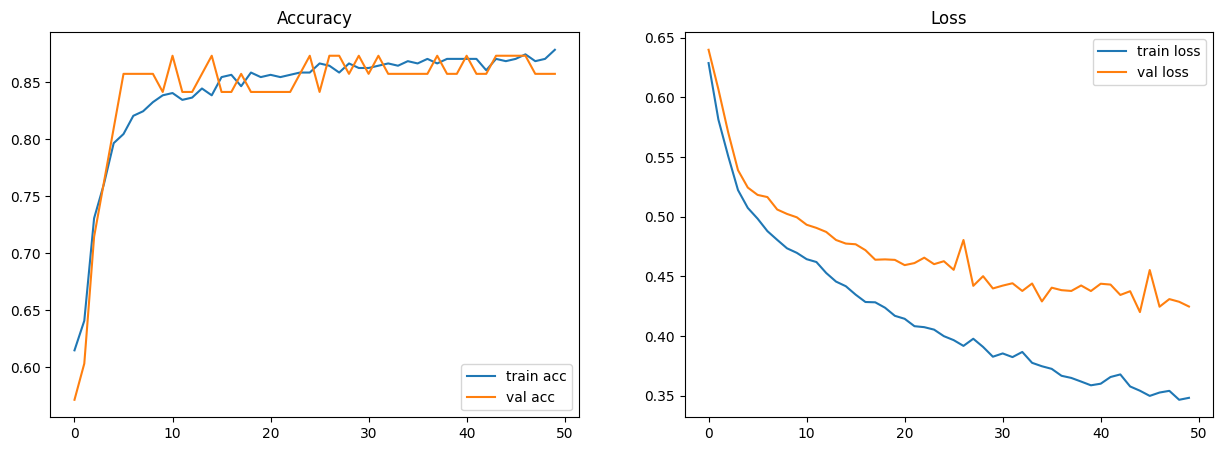

In [8]:
history = history.history

plt.figure(figsize=(15, 5))


plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"], label="train acc")
plt.plot(history["val_accuracy"], label="val acc")
plt.legend()


plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()

plt.show()


In [9]:
loss ,accuracy =model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6765 - loss: 0.6244


In [10]:
print("test loss :",loss)
print("test accuracy:",accuracy)

test loss : 0.6938980221748352
test accuracy: 0.682539701461792


In [11]:
print("Original")
display(df.head())

print("Predicted")
inference = df.head().drop("target", axis=1)

# Select only the relevant columns for inference
inference = inference[numerical_cols + numerical_categorical_cols + categorical_cols]

# Convert dataframe into dictionary format for TensorFlow model
inference_dict = {col: inference[col].values for col in inference.columns}

# Predict using the trained model
inference["target"] = model.predict(inference_dict)

# Display results
display(inference)


Original


,target,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Predicted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


,age,fare,n_siblings_spouses,parch,sex,class,deck,embark_town,alone,target
0,22.0,7.2500,1,0,male,Third,unknown,Southampton,n,0.255393
1,38.0,71.2833,1,0,female,First,C,Cherbourg,n,0.746517
2,26.0,7.9250,0,0,female,Third,unknown,Southampton,y,0.746517
3,35.0,53.1000,1,0,female,First,C,Southampton,n,0.746517
4,28.0,8.4583,0,0,male,Third,unknown,Queenstown,y,0.063647
